# Create map of sample collection locations

## Introduction

The publicly available Pf8 dataset for *Plasmodium falciparum* comprises 33,325 samples, collected by 99 partner studies from 34 countries in Africa, Asia, South America and Oceania between 1966 and 2022. In this notebook, we will generate a figure which shows where the samples of the Pf8 dataset were collected on a global map, highlighting the 122 first-level administrative divisions from which samples were taken within countries. On this figure, points represent sampling locations, coloured according to the major sub-population to which the location is assigned. This notebook will demonstrate the code required to generate this figure panel.

**This notebook should take around 2 minutes to run.**

## Setup

Install the MalariaGEN, basemap, and cartopy packages:

In [1]:
!pip install malariagen_data -q --no-warn-conflicts
!pip install -q --no-warn-conflicts basemap
!pip install -q --no-warn-conflicts cartopy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 66.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.9/775.9 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 6.0 MB/s eta 0:00:00

Load the required Python libraries:

In [2]:
import malariagen_data
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
from cartopy.io import DownloadWarning
from google.colab import drive


## Data Access
Firstly, load the Pf8 metadata. We then check the 'shape' of the data to make sure it is what we were expecting. This is the full metadata for the Pf8 dataset, which includes 33,325 samples, with 17 variables of associated metadata.

In [3]:
# Load Pf8 data
release_data = malariagen_data.Pf8()
sample_metadata = release_data.sample_metadata()

# View the 'shape' of the data - i.e. how many rows and columns does it have?
print(sample_metadata.shape)


(33325, 17)


Often when working with dataframes such as these, it is useful to check the first few rows of the dataset to make sure it is the correct data and in the format we are expecting. You can see each sample has an ID, information on when and where it was collected, and details on their related genetic data.

In [4]:
# View the top few rows of the metadata
sample_metadata.head()

Sample              Study     Country   Admin level 1  Country latitude  \
0   FP0008-C  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   
1   FP0009-C  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   
2  FP0010-CW  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   
3  FP0011-CW  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   
4  FP0012-CW  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   

   Country longitude  Admin level 1 latitude  Admin level 1 longitude    Year  \
0         -10.337093               16.565426                -9.832345  2014.0   
1         -10.337093               16.565426                -9.832345  2014.0   
2         -10.337093               16.565426                -9.832345  2014.0   
3         -10.337093               16.565426                -9.832345  2014.0   
4         -10.337093               16.565426                -9.832345  2014.0   

          ENA All samples same case Population  % callable  QC pass  \
0  ERR1081237              FP0008-C       AF-W       82.48     True   
1  ERR1081238              FP0009-C       AF-W       88.95     True   
2  ERR2889621             FP0010-CW       AF-W       87.01     True   
3  ERR2889624             FP0011-CW       AF-W       86.95     True   
4  ERR2889627             FP0012-CW       AF-W       89.86     True   

  Exclusion reason Sample type  Sample was in Pf7  
0     Analysis_set        gDNA               True  
1     Analysis_set        gDNA               True  
2     Analysis_set        sWGA               True  
3     Analysis_set        sWGA               True  
4     Analysis_set        sWGA               True

## Preparing the data for the figure
In the figure we would like to do three things:

1. Show a world map
2. Highlight the locations from which samples were taken. In our case, this will be as circular points.
2. Colour each point by the sub-population to which the samples were assigned.

To do this, we will start by generating a dictionary object which we can use as a legend for the plot, with the full title for each population:

In [5]:
#You might have noticed the 'Population' variable in the above meta-data does not contain the full name of each population, only an abbreviation.
#Here, we generate a dictionary which contains the full name of each population. This will be useful later in creating a legend for the plot.
Population_legend = collections.OrderedDict()
Population_legend['SA']       = "South America"
Population_legend['AF-W']     = "Africa - West"
Population_legend['AF-C']     = "Africa - Central"
Population_legend['AF-NE']    = "Africa - Northeast"
Population_legend['AF-E']     = "Africa - East"
Population_legend['AS-S-E']   = "Asia - South - East"
Population_legend['AS-S-FE']  = "Asia - South - Far East"
Population_legend['AS-SE-W']  = "Asia - Southeast - West"
Population_legend['AS-SE-E']  = "Asia - Southeast - East"
Population_legend['OC-NG']    = "Oceania - New Guinea"


We would then like to assign each population a colour:

In [6]:
# We create a second dictionary object, where each population is given a hexadecimal colour e.g. #4daf4a
Population_colours = collections.OrderedDict()
Population_colours['SA']      = "#4daf4a"
Population_colours['AF-W']    = "#e31a1c"
Population_colours['AF-C']    = "#fd8d3c"
Population_colours['AF-NE']   = "#bb8129"
Population_colours['AF-E']    = "#fecc5c"
Population_colours['AS-S-E']  = "#dfc0eb"
Population_colours['AS-S-FE'] = "#984ea3"
Population_colours['AS-SE-W'] = "#9ecae1"
Population_colours['AS-SE-E'] = "#3182bd"
Population_colours['OC-NG']   = "#f781bf"

# Then we generate a new variable - 'population colour' onto the metadata, and impute the assigned colours using the dictionary
sample_metadata['Population_colour'] = sample_metadata['Population'].map(Population_colours)

# Note we now have an extra colomn
print(sample_metadata.shape)

# Lets check the above has worked by outputting the first few rows of the data, now with the new Population_colour variable
# you will see each population has now been assigned their corresponding colour
sample_metadata.head()


(33325, 18)


Sample              Study     Country   Admin level 1  Country latitude  \
0   FP0008-C  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   
1   FP0009-C  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   
2  FP0010-CW  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   
3  FP0011-CW  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   
4  FP0012-CW  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   

   Country longitude  Admin level 1 latitude  Admin level 1 longitude    Year  \
0         -10.337093               16.565426                -9.832345  2014.0   
1         -10.337093               16.565426                -9.832345  2014.0   
2         -10.337093               16.565426                -9.832345  2014.0   
3         -10.337093               16.565426                -9.832345  2014.0   
4         -10.337093               16.565426                -9.832345  2014.0   

          ENA All samples same case Population  % callable  QC pass  \
0  ERR1081237              FP0008-C       AF-W       82.48     True   
1  ERR1081238              FP0009-C       AF-W       88.95     True   
2  ERR2889621             FP0010-CW       AF-W       87.01     True   
3  ERR2889624             FP0011-CW       AF-W       86.95     True   
4  ERR2889627             FP0012-CW       AF-W       89.86     True   

  Exclusion reason Sample type  Sample was in Pf7 Population_colour  
0     Analysis_set        gDNA               True           #e31a1c  
1     Analysis_set        gDNA               True           #e31a1c  
2     Analysis_set        sWGA               True           #e31a1c  
3     Analysis_set        sWGA               True           #e31a1c  
4     Analysis_set        sWGA               True           #e31a1c

Next, we would like to count the number of samples from each location. Note that we have three levels of information for each location, making it a little tricky. To get counts for each location, we would like each of three category levels to be included:

 1. The population the sample came from (e.g. East Africa)
 2. The country the sample came from (e.g. Kenya)
 3. The administrative level within each country (e.g. Kilifi)

We therefore need to count the number of samples within each sub-category (e.g. East Africa - Kenya - Kilifi). To do this we can create a new dataframe, where we count the number of samples in each sub-category:

In [7]:
# Here, we create the new dataframe 'sample_metadata_admin1'.
sample_metadata_admin1 = (
    pd.DataFrame(
        sample_metadata                   # we first take the previous dataframe from above
        .groupby(['Population',           # then group the data by several variables (Population, Country & Admin level 1)
                  'Country',
                  'Admin level 1',
                  'Population_colour',    # we also want to include some of the other variables from the previous dataframe (population colour and latitude/longitude)
                  'Admin level 1 latitude',
                  'Admin level 1 longitude'])
        .size()
        .reset_index(name='Number of samples')                       # Then count samples within each subgroup (Population > Country > Admin level 1)
    )

    .set_index(['Country', 'Admin level 1']) # we then set Country and Admin level 1 as the new index
)

# Lets check the above has worked correctly by outputting the new dataframe
pd.options.display.max_rows = 100 # display a maximum of 100 rows
sample_metadata_admin1


Population  \
Country                          Admin level 1                   
Democratic Republic of the Congo Kinshasa                 AF-C   
Kenya                            Kilifi                   AF-E   
Madagascar                       Fianarantsoa             AF-E   
                                 Mahajanga                AF-E   
Malawi                           Chikwawa                 AF-E   
...                                                        ...   
Colombia                         Norte de Santander         SA   
                                 Valle del Cauca            SA   
Honduras                         Francisco Morazan          SA   
Peru                             Loreto                     SA   
Venezuela                        Bolivar                    SA   

                                                    Population_colour  \
Country                          Admin level 1                          
Democratic Republic of the Congo Kinshasa                     #fd8d3c   
Kenya                            Kilifi                       #fecc5c   
Madagascar                       Fianarantsoa                 #fecc5c   
                                 Mahajanga                    #fecc5c   
Malawi                           Chikwawa                     #fecc5c   
...                                                               ...   
Colombia                         Norte de Santander           #4daf4a   
                                 Valle del Cauca              #4daf4a   
Honduras                         Francisco Morazan            #4daf4a   
Peru                             Loreto                       #4daf4a   
Venezuela                        Bolivar                      #4daf4a   

                                                     Admin level 1 latitude  \
Country                          Admin level 1                                
Democratic Republic of the Congo Kinshasa                         -4.436710   
Kenya                            Kilifi                           -3.174404   
Madagascar                       Fianarantsoa                    -21.856236   
                                 Mahajanga                       -16.536991   
Malawi                           Chikwawa                        -16.164374   
...                                                                     ...   
Colombia                         Norte de Santander                8.077473   
                                 Valle del Cauca                   3.868855   
Honduras                         Francisco Morazan                14.283520   
Peru                             Loreto                           -4.123815   
Venezuela                        Bolivar                           6.213313   

                                                     Admin level 1 longitude  \
Country                          Admin level 1                                 
Democratic Republic of the Congo Kinshasa                          15.904241   
Kenya                            Kilifi                            39.686888   
Madagascar                       Fianarantsoa                      46.862308   
                                 Mahajanga                         46.684670   
Malawi                           Chikwawa                          34.708946   
...                                                                      ...   
Colombia                         Norte de Santander               -72.889328   
                                 Valle del Cauca                  -76.531745   
Honduras                         Francisco Morazan                -87.188126   
Peru                             Loreto                           -74.424073   
Venezuela                        Bolivar                          -63.486330   

                                                     Number of samples  
Country                          Admin level 1                          
Democratic Republic of the C

## Plotting Global Map of Pf8 Samples

We can start plotting. Firstly, we set the basic plotting parameters for the plot, such as the font sizes. We then set the range of latitude and longitude we would like to include in the plot, as well as the total size of the image.

In [8]:
# Set basic plotting parameters
rcParams = plt.rcParams
base_font_size = 12
rcParams['font.size'] = base_font_size
rcParams['axes.labelsize'] = base_font_size
rcParams['xtick.labelsize'] = base_font_size
rcParams['ytick.labelsize'] = base_font_size
rcParams['legend.fontsize'] = base_font_size
rcParams['axes.linewidth'] = 1
rcParams['lines.linewidth'] = 1
rcParams['patch.linewidth'] = 1
rcParams['ytick.direction'] = 'out'
rcParams['xtick.direction'] = 'out'
rcParams['lines.markeredgewidth'] = 3
rcParams['figure.max_open_warning'] = 5000

# Define the maximum and minimum latitude and longitude for the map
min_lat = int(sample_metadata_admin1['Admin level 1 latitude'].min()) - 3
max_lat = int(sample_metadata_admin1['Admin level 1 latitude'].max()) + 3
min_long = int(sample_metadata_admin1['Admin level 1 longitude'].min()) - 3
max_long = int(sample_metadata_admin1['Admin level 1 longitude'].max()) + 3

# Then define the total size of the image
map_size = ((int(sample_metadata_admin1['Admin level 1 longitude'].max()) + 3  - int(sample_metadata_admin1['Admin level 1 longitude'].min()) - 3) / 4 ,
(int(sample_metadata_admin1['Admin level 1 latitude'].max()) + 3  -  int(sample_metadata_admin1['Admin level 1 latitude'].min()) - 3 ) / 4 )

Before plotting the sampling locations, we first need to download the map image we will use. This first code chunk downloads an image to use from the Natural Earth Data website, this  will be used to generate the plot.

In [9]:
# First we need to download the map image file via a web link:
!wget https://naturalearth.s3.amazonaws.com/4.1.1/50m_raster/HYP_50M_SR_W.zip

# Unzip if you haven't yet
!unzip './HYP_50M_SR_W.zip'
# the file and define the path to the image file:
image = './HYP_50M_SR_W.tif'


--2025-02-28 11:09:53--  https://naturalearth.s3.amazonaws.com/4.1.1/50m_raster/HYP_50M_SR_W.zip
Resolving naturalearth.s3.amazonaws.com (naturalearth.s3.amazonaws.com)... 52.218.252.27, 52.218.182.187, 52.92.229.129, ...
Connecting to naturalearth.s3.amazonaws.com (naturalearth.s3.amazonaws.com)|52.218.252.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102197904 (97M) [application/zip]
Saving to: ‘HYP_50M_SR_W.zip’

HYP_50M_SR_W.zip    100%[===================>]  97.46M  37.2MB/s    in 2.6s    

2025-02-28 11:09:57 (37.2 MB/s) - ‘HYP_50M_SR_W.zip’ saved [102197904/102197904]

Archive:  ./HYP_50M_SR_W.zip
  inflating: HYP_50M_SR_W.README.html  
 extracting: HYP_50M_SR_W.VERSION.txt  
  inflating: HYP_50M_SR_W.prj        
  inflating: HYP_50M_SR_W.tfw        
  inflating: HYP_50M_SR_W.tif        


Finally, on the background of this world map, we will place scatters on each Admin Level 1 location where there is a sample.

A download of an additional map may be required the first time this cell is run and we can ignore the warning.

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


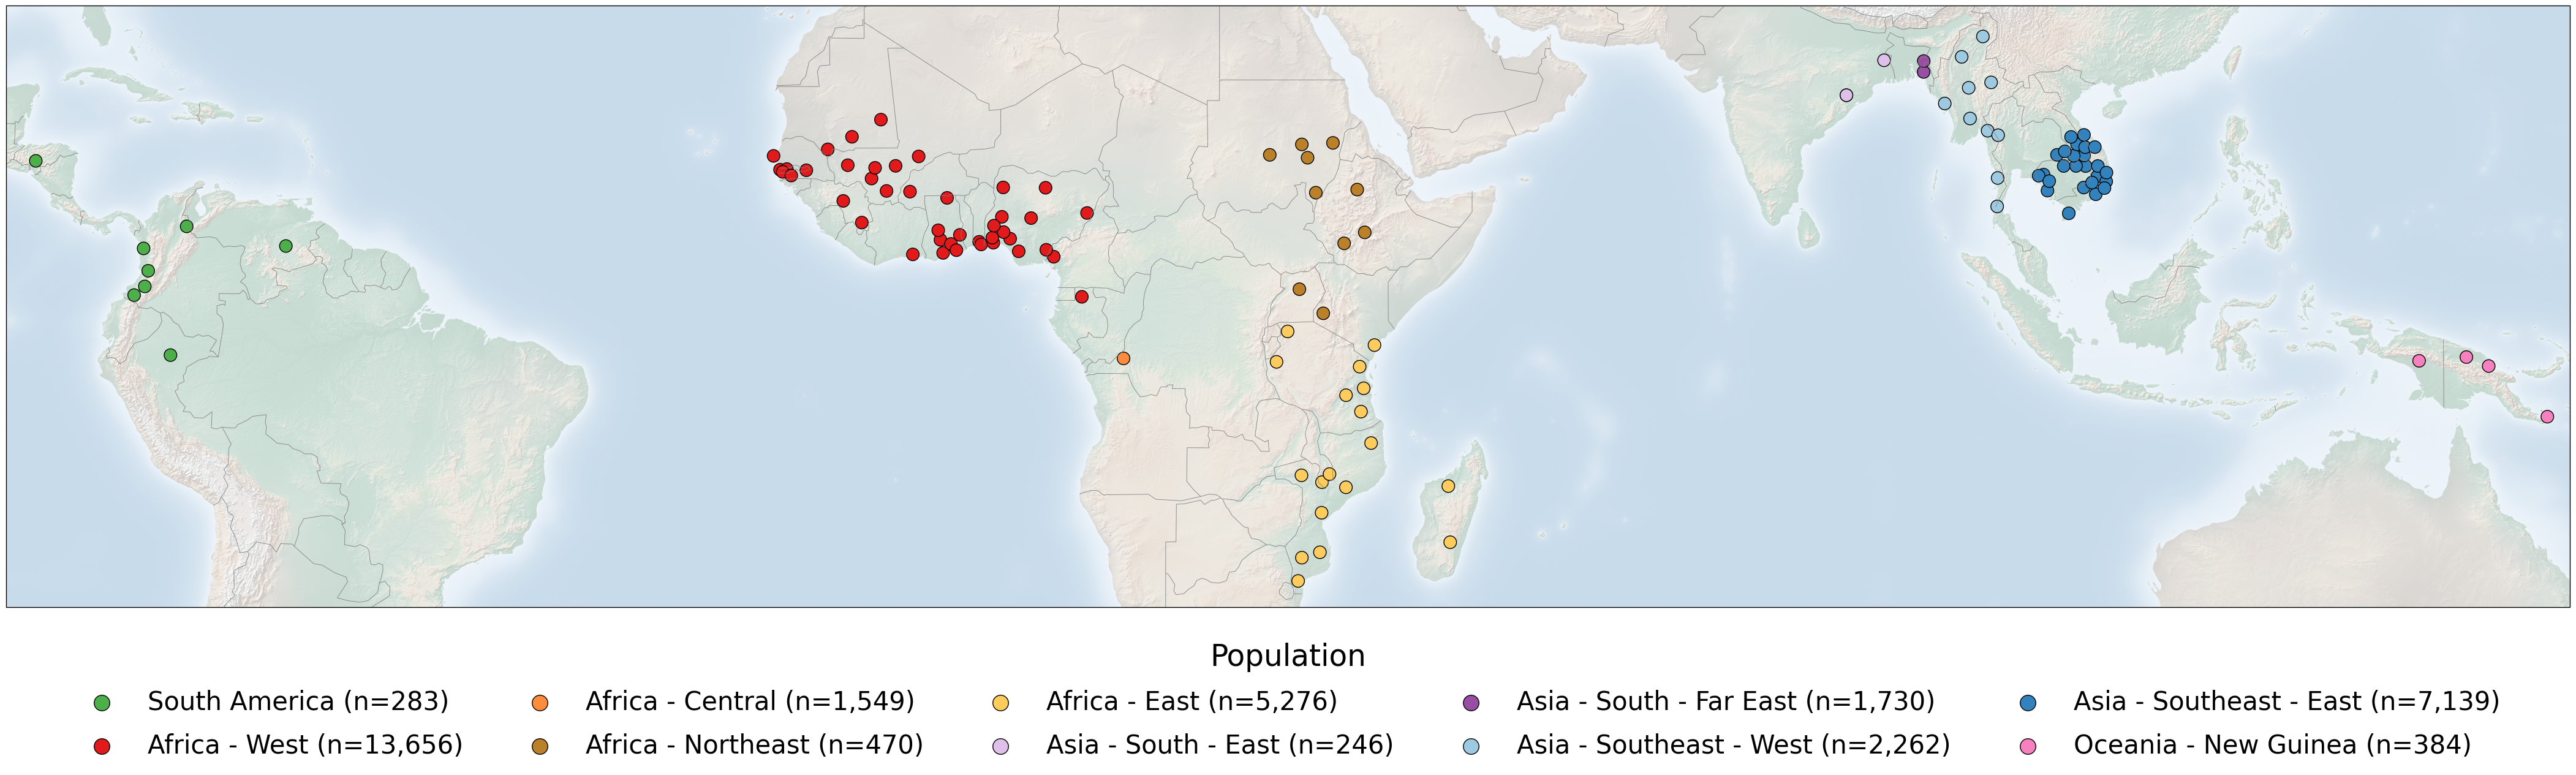

In [10]:
# 1. Define the figure and axes
fig = plt.figure(figsize=map_size)
alpha = 1.0

# 2. Draw the map background with identical parameters
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min_long, max_long,min_lat, max_lat], crs=ccrs.PlateCarree())
ax.imshow(imread(image), origin='upper', alpha = 0.4, transform= ccrs.PlateCarree(),
          extent=[-180, 180, -90, 90])

# Next line after this will download an additional map for drawing borders
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DownloadWarning)

ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.6, edgecolor='grey')

# 3. Show admin 1 levels, with color reflecting population
ax.scatter(
    sample_metadata_admin1['Admin level 1 longitude'],
    sample_metadata_admin1['Admin level 1 latitude'],
    c=sample_metadata_admin1['Population_colour'],
    edgecolors='black',
    s=220,
    alpha=alpha,
    transform=ccrs.PlateCarree()
)

# 4. Make legend with dummy points
for population in Population_colours:
    n = np.count_nonzero(sample_metadata['Population'] == population)
    plt.scatter(
        [],
        [],
        c=Population_colours[population],
        edgecolors='black',
        alpha=alpha,
        s=150,
        label=f"{Population_legend[population]} (n={n:,})"
    )

plt.legend(
    scatterpoints=1,
    frameon=False,
    labelspacing=0.7,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.02),
    ncol = 5,
    fontsize=30,
    markerscale=1.5,
    title = 'Population',
    title_fontsize=35
)

# 5. Add title (optional)
#plt.title("Figure 1A: Sampling locations")

plt.show()


### Save the figure:


In [11]:
# Mount Google Drive
drive.mount('/content/drive')

# Save sampling locations plot
# This will send the file to your Google Drive, where you can download it from if needed
# Note, this code will only save the updated 'cartopy' version of the plot. If you would like to save the original version instead, you will have to comment out the code chunk which generates the map using cartopy (the chunk directly above this one).
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else
file_path = '/content/drive/My Drive/'
file_name = 'Pf8_sample_collections_map'

# We save as both .png and .PDF files
fig.savefig(f'{file_path}{file_name}.png', dpi=350, bbox_inches = 'tight')
fig.savefig(f'{file_path}{file_name}.pdf', dpi=350, bbox_inches = 'tight')

Mounted at /content/drive


## Conclusion

In summary, in this notebook, we accessed the MalariaGEN data available on the cloud for the latest *Plasmodium falciparum* data release (Pf8). We then created the plot showing the global map of the samples and output this as both a .png and .pdf file.
